<a href="https://colab.research.google.com/github/SS1031/kaggle-shopee/blob/main/notebooks/020_shopee_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install ipython-autotime

In [3]:
%load_ext autotime

time: 156 µs (started: 2021-04-07 12:25:36 +00:00)


In [4]:
!mkdir -p "/kaggle/input/"
!cp "/content/drive/MyDrive/kaggle-shopee/shopee-product-matching.zip" "/kaggle/input/"
!unzip -qn "/kaggle/input/shopee-product-matching.zip" -d "/kaggle/input/shopee-product-matching"
!rm -rf "/kaggle/input/shopee-product-matching.zip"

time: 47.1 s (started: 2021-04-07 12:25:36 +00:00)


In [5]:
!cp "/content/drive/MyDrive/kaggle-shopee/shopee-external-models.zip" "/kaggle/input/"
!unzip -qn "/kaggle/input/shopee-external-models.zip" -d "/kaggle/input/"
!pip -q install sentencepiece

     |████████████████████████████████| 1.2MB 5.3MB/s 
time: 40.4 s (started: 2021-04-07 12:26:23 +00:00)


In [ ]:
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official
!pip install -U -q tfds-nightly

In [40]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

time: 5.35 ms (started: 2021-04-07 12:59:02 +00:00)


In [9]:
import os

os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')



Using TPU
time: 17.7 s (started: 2021-04-07 12:30:25 +00:00)


In [21]:
#@title Bert model config
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 
# bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'


map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
time: 99 ms (started: 2021-04-07 12:40:56 +00:00)


In [22]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>
time: 3.44 s (started: 2021-04-07 12:40:58 +00:00)


In [49]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102     0     0     0     0     0     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
time: 31.2 ms (started: 2021-04-07 13:17:52 +00:00)


In [24]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

    Args:
        sentence_features: a list with the names of string-valued features.
        seq_length: an integer that defines the sequence length of BERT inputs.

    Returns:
        A Keras Model that can be called on a list or dict of string Tensors
        (with the order or names, resp., given by sentence_features) and
        returns a dict of tensors for input to BERT.
    """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(tfhub_handle_preprocess)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)

time: 18 ms (started: 2021-04-07 12:41:04 +00:00)


In [25]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
time: 4.22 s (started: 2021-04-07 12:41:06 +00:00)


In [59]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
SEED = 42

def read_and_preprocess(debug=False):
    df = pd.read_csv('/kaggle/input/shopee-product-matching/train.csv')
    if debug:
        df = df.sample(100)
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['matches'] = df['label_group'].map(tmp)
    df['matches'] = df['matches'].apply(lambda x: ' '.join(x))
    encoder = LabelEncoder()
    df['label_group'] = encoder.fit_transform(df['label_group'])
    N_CLASSES = df['label_group'].nunique()
    print(f'We have {N_CLASSES} classes')
    x_train, x_val, y_train, y_val = train_test_split(
        df[['title']], df['label_group'], shuffle=True, stratify=df['label_group'], random_state=SEED, test_size=0.33
    )
    return df, N_CLASSES, x_train, x_val, y_train, y_val


time: 8.14 ms (started: 2021-04-07 13:33:38 +00:00)


In [81]:
df, N_CLASSES, x_train, x_valid, y_train, y_valid = read_and_preprocess()

We have 11014 classes
time: 1.19 s (started: 2021-04-07 14:30:18 +00:00)


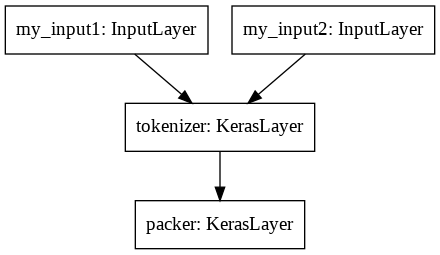

time: 106 ms (started: 2021-04-07 12:41:10 +00:00)


In [26]:
tf.keras.utils.plot_model(test_preprocess_model)

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset_from_tfds(in_memory_ds, info, split, batch_size, bert_preprocess_model):
    is_training = split.startswith('train')
    dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
    num_examples = info.splits[split].num_examples

    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset, num_examples


time: 6.71 ms (started: 2021-04-07 12:41:15 +00:00)


In [143]:
def load_shopee_title_dataset(X, y, is_training, batch_size, bert_preprocess_model):

    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x, y: (bert_preprocess_model(x), y))
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return dataset, len(X)


train_dataset, num_samples = load_shopee_title_dataset(
    x_train.values, y_train.values, True, batch_size=32, bert_preprocess_model=bert_preprocess_model
)



time: 142 ms (started: 2021-04-07 15:39:04 +00:00)


In [115]:
def build_classifier_model(num_classes):
    inputs = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    )
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')
    net = encoder(inputs)['pooled_output']
    net = tf.keras.layers.Dropout(rate=0.1)(net)
    net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
    # net = tf.keras.layers.Softmax(num_classes, dtype="float32")(net)

    return tf.keras.Model(inputs, net, name='prediction')

time: 6.81 ms (started: 2021-04-07 15:09:21 +00:00)


In [116]:
model = build_classifier_model(N_CLASSES)

time: 15.7 s (started: 2021-04-07 15:09:23 +00:00)


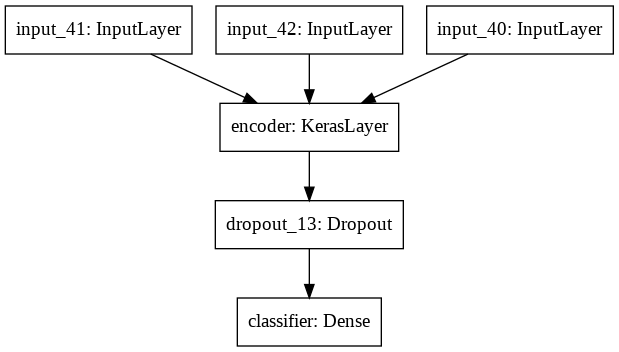

time: 609 ms (started: 2021-04-07 15:09:38 +00:00)


In [117]:
tf.keras.utils.plot_model(model)

In [118]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.3456716 0.6795987]], shape=(1, 2), dtype=float32)
time: 23.6 s (started: 2021-04-07 15:09:51 +00:00)


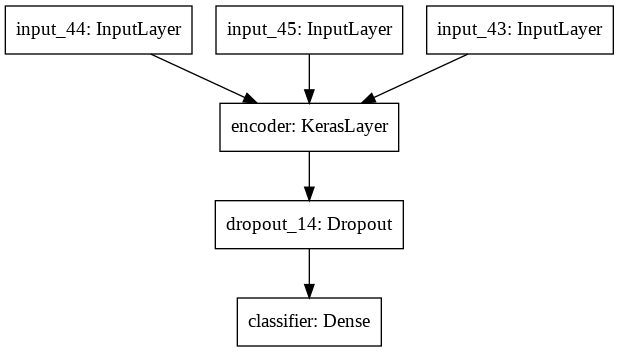

time: 624 ms (started: 2021-04-07 15:10:14 +00:00)


In [119]:
tf.keras.utils.plot_model(test_classifier_model)

In [120]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
    validation_split = 'validation_matched'
    test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
    # batch_size=-1 is a way to load the dataset into memory
    in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
    samples = [sample_row[feature] for feature in sentence_features]
    print(f'sample row {sample_i}')
    for sample in samples:
        print(sample.numpy())
    sample_label = sample_row['label']

    print(f'label: {sample_label} ({labels_names[sample_label]})')
    print()
    sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)

time: 932 ms (started: 2021-04-07 15:10:15 +00:00)


In [32]:
def get_configuration(glue_task):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    if glue_task == 'glue/cola':
        metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
    else:
        metrics = tf.keras.metrics.SparseCategoricalAccuracy(
            'accuracy', dtype=tf.float32
        )
    return metrics, loss


time: 3.71 ms (started: 2021-04-07 12:45:44 +00:00)


In [125]:
glue_train_dataset, _ = load_dataset_from_tfds(
    in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model
)
shopee_train_dataset, _= load_shopee_title_dataset(
    x_train.values, y_train.values, batch_size, bert_preprocess_model
)
shopee_valid_dataset, _= load_shopee_title_dataset(
    x_valid.values, y_valid.values, batch_size, bert_preprocess_model
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


time: 252 ms (started: 2021-04-07 15:18:42 +00:00)


In [126]:
glue_train_dataset

<PrefetchDataset shapes: ({input_type_ids: (None, 128), input_word_ids: (None, 128), input_mask: (None, 128)}, (None,)), types: ({input_type_ids: tf.int32, input_word_ids: tf.int32, input_mask: tf.int32}, tf.int64)>

time: 12.5 ms (started: 2021-04-07 15:18:45 +00:00)


In [127]:
sample_i = 1
print("Glue Sample Batch")
for sample_row in glue_train_dataset.take(1):
    print(sample_row)
print("\n\n")
print("Shopee Sample Batch Train")
for sample_row in shopee_train_dataset.take(1):
    print(sample_row)
print("\n\n")
print("Shopee Sample Batch Valid")
for sample_row in shopee_valid_dataset.take(1):
    print(sample_row)

Glue Sample Batch
({'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  6294,  2097, ...,     0,     0,     0],
       [  101, 11021,  4197, ...,     0,     0,     0],
       [  101,  2061,  9414, ...,     0,     0,     0],
       ...,
       [  101,  1996,  2346, ...,     0,     0,     0],
       [  101,  2198,  5720, ...,     0,     0,     0],
       [  101,  1996,  7144, ...,     0,     0,     0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0,

In [123]:
validation_dataset

<PrefetchDataset shapes: ({input_type_ids: (None, 128), input_word_ids: (None, 128), input_mask: (None, 128)}, (None,)), types: ({input_type_ids: tf.int32, input_word_ids: tf.int32, input_mask: tf.int32}, tf.int64)>

time: 8.51 ms (started: 2021-04-07 15:17:13 +00:00)


In [ ]:
epochs = 25
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

    # metric have to be created inside the strategy scope
    metrics, loss = get_configuration("")

    # train_dataset, train_data_size = load_dataset_from_tfds(
    #     in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model
    # )
    train_dataset, train_data_size = load_shopee_title_dataset(
        x_train.values, y_train.values, True, batch_size, bert_preprocess_model
    )

    steps_per_epoch = train_data_size // batch_size
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = num_train_steps // 10

    # validation_dataset, validation_data_size = load_dataset_from_tfds(
    #     in_memory_ds, tfds_info, validation_split, batch_size, bert_preprocess_model
    # )
    # validation_dataset, validation_data_size = load_shopee_title_dataset(
    #     x_valid.values, y_valid.values, False, batch_size, bert_preprocess_model
    # )
    validation_dataset, validation_data_size = load_shopee_title_dataset(
        x_train.values, y_train.values, False, batch_size, bert_preprocess_model
    )
    validation_steps = validation_data_size // batch_size

    # classifier_model = build_classifier_model(num_classes)
    classifier_model = build_classifier_model(N_CLASSES)

    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type="adamw"
    )

    classifier_model.compile(
        optimizer=optimizer,
        loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    checkpoint = ModelCheckpoint(
        f'/content/drive/MyDrive/kaggle-shopee/samples/bert-arcface.h5', 
        monitor='val_loss', 
        save_best_only=True,
        save_weights_only=True, 
        mode='min'
    )

    classifier_model.fit(
        x=train_dataset,
        validation_data=validation_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_steps=100,
        callbacks=[checkpoint]
    )

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


In [38]:
main_save_path = '/content/drive/MyDrive/kaggle-shopee/samples/my-bert-model'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving /content/drive/MyDrive/kaggle-shopee/samples/my-bert-model/glue_cola_bert_en_uncased_L-12_H-768_A-12


time: 33.6 s (started: 2021-04-07 12:53:26 +00:00)


In [39]:
with tf.device('/job:localhost'):
    reloaded_model = tf.saved_model.load(saved_model_path)

time: 30.4 s (started: 2021-04-07 12:54:36 +00:00)


In [130]:
steps_per_epoch

717

time: 4.57 ms (started: 2021-04-07 15:32:50 +00:00)


In [131]:
validation_steps

353

time: 5.77 ms (started: 2021-04-07 15:32:56 +00:00)


In [133]:
validation_data_size

11303

time: 4.46 ms (started: 2021-04-07 15:33:24 +00:00)


In [134]:
x_train


,title
10914,Parfum baby zwitsbaby 30 ml
22233,\xe3\x80\x90Bayar Di Tempat\xe3\x80\x91Brush A...
3925,DINNY- Piyama SIZE 11 usia 9 s/d 10 tahun
4133,Tanaman Artifisial Model Imitasi untuk Dekorasi
27840,Tisu Tissue Lap Alkohol Pembersih LCD Tempered...
...,...
32690,Domino Block Mainan Kayu Puzzle Susun Games Ke...
14056,Mainan Anak Avenger Iron Man Smart Dance Robot...
28975,LECICAPS - pelancar asi
10568,Rangkaian bunga mawar sepeda mini BP014


time: 77.3 ms (started: 2021-04-07 15:33:54 +00:00)


In [136]:
x_valid

,title
8440,Theraskin Acne Glow White - Acne White Glow
16471,[RESELLER RESMI MASKYOURNEEDS] FREE GIFT
10062,SEPATU SNEAKER SEPATU SEKOLAH SEPATU SNEAKERS ...
28800,Kompor Camping Gas Portable Kecil merek KOVAR ...
3715,Madu anak Vitabumin original
...,...
12256,Adidas Badminton Spieler E68 10M Badminton String
15102,Grosiran CHARGER OPPO ORIGINAL 100%\nREAL 2 AM...
31860,ciput ninja hanum_id PEONY
5028,PANCI LISTRIK MULTIFUNGSI LAPIS KERAMIK / PANC...


time: 17.6 ms (started: 2021-04-07 15:34:06 +00:00)


In [137]:
validation_steps * 32

11296

time: 11.1 ms (started: 2021-04-07 15:34:18 +00:00)


In [138]:
validation_data_size // batch_size


353

time: 5.3 ms (started: 2021-04-07 15:34:51 +00:00)


In [140]:
validation_steps * batch_size

11296

time: 4.02 ms (started: 2021-04-07 15:35:17 +00:00)


In [141]:
steps_per_epoch * batch_size

22944

time: 4.37 ms (started: 2021-04-07 15:35:26 +00:00)
